# Имплементация модели и её обучение

In [1]:
import glob
import os
import sys
import math
import time
import random
import pickle
import joblib
from tqdm import tqdm
import torch

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.modules.normalization import LayerNorm

In [2]:
dataset_pickle = '/home/storage/3020/db/K_cluster2_backup/TD/data/data_split.pkl'
with open(dataset_pickle, 'rb') as f:
    files = pickle.load(f)

train_list, val_list, test_list = [], [], []

for file in tqdm(files['train']):
    seqs = joblib.load(file)
    name = file.split('/')[-1]

    for idx, seq in enumerate(seqs):
        if len(seq) == 0:
            continue
        train_list.append(seq)
        
for file in tqdm(files['val']):
    seqs = joblib.load(file)
    name = file.split('/')[-1]
    for idx, seq in enumerate(seqs):
        if len(seq) == 0:
            continue
        val_list.append(seq)
    
for file in tqdm(files['test']):
    seqs = joblib.load(file)
    for idx, seq in enumerate(seqs):
        if len(seq) == 0:
            continue
        test_list.append(seq)

100%|██████████| 125/125 [01:39<00:00,  1.26it/s]


In [3]:
print(f'Train length: {len(train_list)}')
print(f'Val length: {len(val_list)}')
print(f'Test length: {len(test_list)}')

Train length: 293775
Val length: 37065
Test length: 34815


# Constants

In [4]:
SEQUENCE_START = 0
RANGE_NOTE_ON = 128
RANGE_NOTE_OFF = 128
RANGE_VEL = 32
RANGE_TIME_SHIFT = 100

START_IDX = {
    'note_on': 0,
    'note_off': RANGE_NOTE_ON,
    'time_shift': RANGE_NOTE_ON + RANGE_NOTE_OFF,
    'velocity': RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_TIME_SHIFT
}


SEPERATOR               = "========================="

# Taken from the paper
ADAM_BETA_1             = 0.9
ADAM_BETA_2             = 0.98
ADAM_EPSILON            = 10e-9

LR_DEFAULT_START        = 1.0
SCHEDULER_WARMUP_STEPS  = 4000
# LABEL_SMOOTHING_E       = 0.1

# DROPOUT_P               = 0.1

TOKEN_END               = RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_VEL + RANGE_TIME_SHIFT
TOKEN_PAD               = TOKEN_END + 1

VOCAB_SIZE              = TOKEN_PAD + 1

TORCH_FLOAT             = torch.float32
TORCH_INT               = torch.int32

TORCH_LABEL_TYPE        = torch.long

PREPEND_ZEROS_WIDTH     = 4

TORCH_CPU_DEVICE = torch.device("cpu")
USE_CUDA = 1
TORCH_CUDA_DEVICE = torch.device("cuda:8")

In [5]:
def cpu_device():
    """
    ----------
    Author: Damon Gwinn
    ----------
    Grabs the cpu device
    ----------
    """

    return TORCH_CPU_DEVICE

def get_device():
    """
    ----------
    Author: Damon Gwinn
    ----------
    Grabs the default device. Default device is CUDA if available and use_cuda is not False, CPU otherwise.
    ----------
    """

    if((not USE_CUDA) or (TORCH_CUDA_DEVICE is None)):
        return TORCH_CPU_DEVICE
    else:
        return TORCH_CUDA_DEVICE

# Dataset

In [6]:
class EPianoDataset(Dataset):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Pytorch Dataset for the Maestro e-piano dataset (https://magenta.tensorflow.org/datasets/maestro).
    Recommended to use with Dataloader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
    Uses all files found in the given root directory of pre-processed (preprocess_midi.py)
    Maestro midi files.
    ----------
    """

    def __init__(self, midi_list, max_seq=2048, random_seq=True):
        self.max_seq    = max_seq
        self.random_seq = random_seq
        self.data_files = midi_list

    def __len__(self):
        """
        ----------
        Author: Damon Gwinn
        ----------
        How many data files exist in the given directory
        ----------
        """

        return len(self.data_files)

    def __getitem__(self, idx):
        """
        ----------
        Author: Damon Gwinn
        ----------
        Gets the indexed midi batch. Gets random sequence or from start depending on random_seq.
        Returns the input and the target.
        ----------
        """

        raw_mid = torch.tensor(self.data_files[idx], dtype=TORCH_LABEL_TYPE, device=cpu_device())
        x, tgt = process_midi(raw_mid, self.max_seq, self.random_seq)

        return x, tgt
    
def process_midi(raw_mid, max_seq, random_seq):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Takes in pre-processed raw midi and returns the input and target. Can use a random sequence or
    go from the start based on random_seq.
    ----------
    """

    x   = torch.full((max_seq, ), TOKEN_PAD, dtype=TORCH_LABEL_TYPE, device=cpu_device())
    tgt = torch.full((max_seq, ), TOKEN_PAD, dtype=TORCH_LABEL_TYPE, device=cpu_device())

    raw_len     = len(raw_mid)
    full_seq    = max_seq + 1 # Performing seq2seq

    if(raw_len == 0):
        return x, tgt

    if(raw_len < full_seq):
        if tgt.shape[0] == raw_len:
            #print(f'Tgt shape: {tgt.shape} Raw len: {raw_len} Skipping')
            x[:raw_len]         = raw_mid
            tgt[:raw_len-1]     = raw_mid[1:]
            tgt[raw_len-1]        = TOKEN_END
        else:
            x[:raw_len]         = raw_mid
            tgt[:raw_len-1]     = raw_mid[1:]
            tgt[raw_len]        = TOKEN_END
    else:
        # Randomly selecting a range
        if(random_seq):
            end_range = raw_len - full_seq
            start = random.randint(SEQUENCE_START, end_range)

        # Always taking from the start to as far as we can
        else:
            start = SEQUENCE_START

        end = start + full_seq

        data = raw_mid[start:end]

        x = data[:max_seq]
        tgt = data[1:full_seq]

    return x, tgt

Гиперпараметры обучения и параметры модели

In [7]:
weight_modulus = 1
print_modulus = 1
n_workers = 1

lr = None
ce_smoothing = None
batch_size = 12
random_seq = True
epochs = 100

max_seq = 2048
n_layers = 6
num_heads = 8
d_model = 512
dim_feedforward = 1024
dropout = 0.1

Инициализируем датасеты собранными списками последовательностей

In [8]:
train_dataset = EPianoDataset(train_list, max_seq, random_seq)
val_dataset = EPianoDataset(val_list, max_seq, random_seq)
test_dataset = EPianoDataset(test_list, max_seq, random_seq)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers)

Проверим выходные шейпы

In [11]:
print('Train loader')
for x, tgt in train_loader:
    print(f'X shape: {x.shape}')
    print(f'Target shape: {tgt.shape}')
    break

print('Validation loader')
for x, tgt in val_loader:
    print(f'X shape: {x.shape}')
    print(f'Target shape: {tgt.shape}')
    break

print('Test loader')
for x, tgt in test_loader:
    print(f'X shape: {x.shape}')
    print(f'Target shape: {tgt.shape}')
    break

Train loader
X shape: torch.Size([8, 2048])
Target shape: torch.Size([8, 2048])
Validation loader
X shape: torch.Size([8, 2048])
Target shape: torch.Size([8, 2048])
Test loader
X shape: torch.Size([8, 2048])
Target shape: torch.Size([8, 2048])


# Инициализация модели, оптимизатора и schedulera

In [10]:
class LrStepTracker:

    def __init__(self, model_dim=512, warmup_steps=4000, init_steps=0):
        # Store Values
        self.warmup_steps = warmup_steps
        self.model_dim = model_dim
        self.init_steps = init_steps

        # Begin Calculations
        self.invsqrt_dim = (1 / math.sqrt(model_dim))
        self.invsqrt_warmup = (1 / (warmup_steps * math.sqrt(warmup_steps)))

    # step
    def step(self, step):

        step += self.init_steps
        if(step <= self.warmup_steps):
            return self.invsqrt_dim * self.invsqrt_warmup * step
        else:
            invsqrt_step = (1 / math.sqrt(step))
            return self.invsqrt_dim * invsqrt_step

# get_lr
def get_lr(optimizer):

    for param_group in optimizer.param_groups:
        return param_group['lr']

In [11]:
def train(cur_epoch, model, dataloader, loss, opt, lr_scheduler=None, num_iters=-1):
    best_eval_acc        = 0.0
    best_eval_acc_epoch  = -1
    best_eval_loss       = float("inf")
    best_eval_loss_epoch = -1
    loss_hist = []
    
    out = -1
    model.train()
    with tqdm(total=len(dataloader)) as bar_train:
        for batch_num, batch in enumerate(dataloader):
            time_before = time.time()

            opt.zero_grad()

            x   = batch[0].to(get_device())
            tgt = batch[1].to(get_device())

            y, _ = model(x)

            y   = y.reshape(y.shape[0] * y.shape[1], -1)
            tgt = tgt.flatten()

            out = loss.forward(y, tgt)

            out.backward()
            opt.step()

            if(lr_scheduler is not None):
                lr_scheduler.step()

            time_after = time.time()
            time_took = time_after - time_before
            lr = opt.param_groups[0]['lr']
            bar_train.set_description(f'Epoch: {cur_epoch} Loss: {float(out):.4} LR: {float(lr):.8}')
            bar_train.update(1)
            loss_hist.append(out.item())
            if batch_num == num_iters:
                break

    return loss_hist

def compute_epiano_accuracy(out, tgt):
    softmax = nn.Softmax(dim=-1)
    out = torch.argmax(softmax(out), dim=-1)

    out = out.flatten()
    tgt = tgt.flatten()

    mask = (tgt != TOKEN_PAD)

    out = out[mask]
    tgt = tgt[mask]

    if(len(tgt) == 0):
        return 1.0

    num_right = (out == tgt)
    num_right = torch.sum(num_right).type(TORCH_FLOAT)

    acc = num_right / len(tgt)

    return acc

def eval_model(model, dataloader, loss, num_iters=-1):
    model.eval()

    avg_acc     = -1
    avg_loss    = -1
    with torch.set_grad_enabled(False):
        n_test      = len(dataloader)
        sum_loss   = 0.0
        sum_acc    = 0.0
        with tqdm(total=len(dataloader)) as bar_eval:
            for batch in dataloader:
                x   = batch[0].to(get_device())
                tgt = batch[1].to(get_device())

                y, _ = model(x)

                sum_acc += float(compute_epiano_accuracy(y, tgt))

                y   = y.reshape(y.shape[0] * y.shape[1], -1)
                tgt = tgt.flatten()

                out = loss.forward(y, tgt)

                sum_loss += float(out)
                bar_eval.set_description(f'Loss val: {float(out):.4}  Acc: {float(sum_acc / (bar_eval.n + 1)):.4}')
                bar_eval.update(1)
                if bar_eval.n == num_iters:
                    break

        avg_loss    = sum_loss / n_test
        avg_acc     = sum_acc / n_test

    return avg_loss, avg_acc

In [12]:
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, config.dim_feedforward),
            nn.GELU(),
            nn.Linear(config.dim_feedforward, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=-1)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss
    
    def generate(self, primer=None, target_seq_length=1024, beam=0, beam_chance=1.0):

        assert (not self.training), "Cannot generate while in training mode"

        print("Generating sequence of max length:", target_seq_length)

        gen_seq = torch.full((1,target_seq_length), TOKEN_PAD, dtype=TORCH_LABEL_TYPE, device=get_device())

        num_primer = len(primer)
        gen_seq[..., :num_primer] = primer.type(TORCH_LABEL_TYPE).to(get_device())

        cur_i = num_primer
        while(cur_i < target_seq_length):
            logits, _ = self.forward(gen_seq[..., :cur_i])
            y = self.softmax(logits)[..., :TOKEN_END]
            token_probs = y[:, cur_i-1, :]

            if(beam == 0):
                beam_ran = 2.0
            else:
                beam_ran = random.uniform(0,1)

            if(beam_ran <= beam_chance):
                token_probs = token_probs.flatten()
                top_res, top_i = torch.topk(token_probs, beam)

                beam_rows = top_i // VOCAB_SIZE
                beam_cols = top_i % VOCAB_SIZE

                gen_seq = gen_seq[beam_rows, :]
                gen_seq[..., cur_i] = beam_cols

            else:
                distrib = torch.distributions.categorical.Categorical(probs=token_probs)
                next_token = distrib.sample()
                gen_seq[:, cur_i] = next_token


                # Let the transformer decide to end if it wants to
                if(next_token == TOKEN_END):
                    print("Model called end of sequence at:", cur_i, "/", target_seq_length)
                    break

            cur_i += 1
            if(cur_i % 50 == 0):
                print(cur_i, "/", target_seq_length)

        return gen_seq[:, :cur_i]

In [13]:
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, dim_feedforward, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.dim_feedforward = dim_feedforward
        for k,v in kwargs.items():
            setattr(self, k, v)
import logging
logger = logging.getLogger(__name__)

In [14]:
config = GPTConfig(VOCAB_SIZE, 
                  max_seq,
                  dim_feedforward=dim_feedforward,
                  n_layer=6, 
                  n_head=8, 
                  n_embd=512)
model = GPT(config).to(get_device())
model

GPT(
  (tok_emb): Embedding(390, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): GELU()
        (2): Linear(in_features=1024, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      

In [15]:
model = nn.DataParallel(model, device_ids=[8,7,9,6])

In [16]:
init_step = 0
lr = LR_DEFAULT_START
lr_stepper = LrStepTracker(d_model, SCHEDULER_WARMUP_STEPS, init_step)
eval_loss_func = nn.CrossEntropyLoss(ignore_index=TOKEN_PAD)
train_loss_func = eval_loss_func

opt = Adam(model.parameters(), lr=lr, betas=(ADAM_BETA_1, ADAM_BETA_2), eps=ADAM_EPSILON)
lr_scheduler = LambdaLR(opt, lr_stepper.step)

n_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers)

In [ ]:
best_eval_acc        = 0.0
best_eval_acc_epoch  = -1
best_eval_loss       = float("inf")
best_eval_loss_epoch = -1
best_acc_file = '/home/storage/3020/db/K_cluster2_backup/TD/gpt2_best_acc_bsize12.pth'
best_loss_file = '/home/storage/3020/db/K_cluster2_backup/TD/gpt2_best_loss_bsize12.pth'
loss_train, loss_val, acc_val = [], [], []

for epoch in range(0, epochs):
    new_best = False
    
    loss = train(epoch+1, model, train_loader, train_loss_func, opt, lr_scheduler, num_iters=-1)
    loss_train.append(loss)
    
    eval_loss, eval_acc = eval_model(model, val_loader, eval_loss_func, num_iters=-1)
    loss_val.append(eval_loss)
    acc_val.append(eval_acc)
    
    if(eval_acc > best_eval_acc):
        best_eval_acc = eval_acc
        best_eval_acc_epoch  = epoch+1
        torch.save(model.state_dict(), best_acc_file)
        new_best = True

    if(eval_loss < best_eval_loss):
        best_eval_loss       = eval_loss
        best_eval_loss_epoch = epoch+1
        torch.save(model.state_dict(), best_loss_file)
        new_best = True
    
    if(new_best):
        print("Best eval acc epoch:", best_eval_acc_epoch)
        print("Best eval acc:", best_eval_acc)
        print("")
        print("Best eval loss epoch:", best_eval_loss_epoch)
        print("Best eval loss:", best_eval_loss)

  0%|          | 0/24482 [00:00<?, ?it/s]

Best eval acc epoch: 1
Best eval acc: 0.384279597428826

Best eval loss epoch: 1
Best eval loss: 2.054124534072209


  0%|          | 0/24482 [00:00<?, ?it/s]

Best eval acc epoch: 2
Best eval acc: 0.3955075197975857

Best eval loss epoch: 2
Best eval loss: 1.994569742282103


Epoch: 3 Loss: 1.973 LR: 0.00017112309:  72%|███████▏  | 17734/24482 [1:41:24<35:34,  3.16it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 1.873 LR: 0.00016808243:  82%|████████▏ | 20169/24482 [1:55:26<22:49,  3.15it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 3 Loss: 1.833 LR: 0.00016521446:  92%|█████████▏| 22589/24482 [2:09:30<09:49,  3.21it/s]  IOPub message rate exceeded.
The notebook server will temp

Best eval acc epoch: 3
Best eval acc: 0.40110184190998033

Best eval loss epoch: 3
Best eval loss: 1.9650320271605926


Epoch: 4 Loss: 1.783 LR: 0.00016264574:   2%|▏         | 386/24482 [02:14<2:05:04,  3.21it/s] 

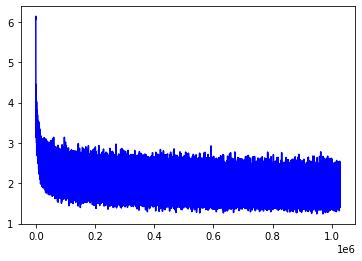

In [66]:
import matplotlib.pyplot as plt
tr_loss_list = [item for sublist in loss_train for item in sublist]
plt.plot([i for i in range(len(tr_loss_list))] ,tr_loss_list, 'b')

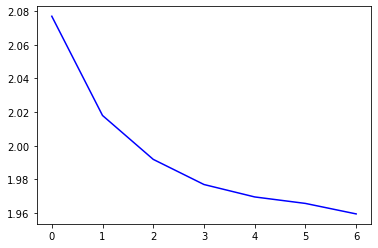

In [67]:
plt.plot([i for i in range(len(loss_val))], loss_val, 'b')

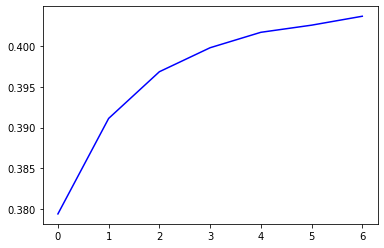

In [68]:
plt.plot([i for i in range(len(acc_val))], acc_val, 'b')

In [71]:
res_dict = {'tr_loss': tr_loss_list,
            'loss_val': loss_val,
            'acc_val': acc_val,
            'n_layers': 6,
            'num_heads': 8,
            'n_embd': 512,
            'block_size': model.get_block_size(),
            'dim_feedforward': 2048,
            'dropout': dropout,
            'max_seq': max_seq,
            'VOCAB_SIZE': VOCAB_SIZE}
with open('/home/storage/3020/db/K_cluster2_backup/TD/gpt2_best_acc_bsize2_scores_params.pkl', 'wb') as f:
    pickle.dump(res_dict, f)

In [178]:
model.load_state_dict(torch.load(best_acc_file))

<All keys matched successfully>

In [69]:
model.get_block_size() 

2048